In [1]:
# Download dataset from google drive
file_id = '1jYCRE0n_qxSw67s9lZhNCoST5yeH-eww'
file_zip = 'dataset.zip'

drive_link = f'https://drive.google.com/uc?id={file_id}'
!gdown $drive_link -O $file_zip
!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Healthy/Healthy/H41/02SOUHL/6MK2X.WAV  
   creating: dataset/Healthy/Healthy/H41/03_1SL/
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3BE.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3BER.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3KRK.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3LA.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3NOS.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3PE.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3PRO.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3PRST.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3VLA.WAV  
   creating: dataset/Healthy/Healthy/H41/04_2SL/
  inflating: dataset/Healthy/Healthy/H41/04_2SL/6MK4KOLO.WAV  
  inflating: dataset/Healthy/Healthy/H41/04_2SL/6MK4PAP.WAV  
  inflating: dataset/Healthy/Healthy/H41/04_2SL/6MK4PIVO.WAV  
  inflating: dataset/Healthy/Healthy/H41/04_2S

In [2]:
import os
import pandas as pd
import librosa
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [3]:
# Define path
dysarthria_path = '/content/dataset/Dysarthria'
SLI_path = '/content/dataset/SLI'
healthy_path = '/content/dataset/Healthy'

In [4]:
# Create list
category = []
speech_type = []
paths = []

In [5]:
# Append file path and label
def process_directory(directory, type_label, category_label):
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith('.wav'):
                paths.append(os.path.join(root, filename))
                category.append(category_label)
                speech_type.append(type_label)

In [6]:
# Populate list
process_directory(SLI_path, 'Speech Delay', 'SLI')
process_directory(dysarthria_path, 'Speech Delay', 'Dysarthria')
process_directory(healthy_path, 'Normal', 'Healthy')

In [7]:
# Create dataframe
main_df = pd.DataFrame({
    'Category': category,
    'Type': speech_type,
    'Path': paths
})

print(main_df.head())
print(main_df['Type'].value_counts())

  Category          Type                                          Path
0      SLI  Speech Delay   /content/dataset/SLI/P32/04_2SL/4sp4trd.wav
1      SLI  Speech Delay   /content/dataset/SLI/P32/04_2SL/4sp4sok.wav
2      SLI  Speech Delay   /content/dataset/SLI/P32/04_2SL/4sp4pap.wav
3      SLI  Speech Delay  /content/dataset/SLI/P32/04_2SL/4sp4pivo.wav
4      SLI  Speech Delay  /content/dataset/SLI/P32/04_2SL/4sp4kolo.wav
Type
Normal          2142
Speech Delay    1391
Name: count, dtype: int64


In [8]:
# Load audio files and process waveform
def load_audio_waveform(audio_path, sr=16000):
    waveform, _ = librosa.load(audio_path, sr=sr, mono=True)
    return waveform

In [9]:
# Load waveform
waveforms = []
for path in main_df['Path']:
    try:
        waveform = load_audio_waveform(path)
        waveforms.append(waveform)
    except Exception as e:
        print(f"Error loading {path}: {e}")
        waveforms.append(None)

# Add waveform to dataframe
main_df['Waveform'] = waveforms
main_df = main_df.dropna(subset=['Waveform'])

In [10]:
# Convert 'Type' column to numerical
label_encoder = LabelEncoder()
main_df['Label'] = label_encoder.fit_transform(main_df['Type'])

In [11]:
# Load YAMNet for extracting audio
yamnet_url = "https://tfhub.dev/google/yamnet/1"
yamnet_layer = hub.KerasLayer(yamnet_url, trainable=False)

def extract_yamnet_features(waveform, sr=16000):
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    scores, embeddings, _ = yamnet_layer(waveform)
    return tf.reduce_mean(embeddings, axis=0).numpy()  # Average pooling

# Apply feature extraction to waveforms
features = []
for wf in main_df['Waveform']:
    try:
        feat = extract_yamnet_features(wf)
        features.append(feat)
    except Exception as e:
        print(f"Error extracting features: {e}")
        features.append(None)

# Add features to dataframe
main_df['Features'] = features
main_df = main_df.dropna(subset=['Features'])

In [12]:
# Split dataset
X = np.stack(main_df['Features'].values)
y = main_df['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 594,625 (2.27 MB)

 Trainable params: 594,625 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6028 - loss: 1.4103 - val_accuracy: 0.8402 - val_loss: 0.8621
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7259 - loss: 0.9268 - val_accuracy: 0.8557 - val_loss: 0.7030
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8152 - loss: 0.7573 - val_accuracy: 0.8670 - val_loss: 0.6217
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8371 - loss: 0.7084 - val_accuracy: 0.8911 - val_loss: 0.5793
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8412 - loss: 0.6642 - val_accuracy: 0.8883 - val_loss: 0.5295
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8504 - loss: 0.6191 - val_accuracy: 0.9081 - val_loss: 0.5067
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8648 - loss: 0.5908 - val_accuracy: 0.9109 - val_loss: 0.4667
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8852 - loss: 0.5623 - val_accuracy: 0.9208 - v

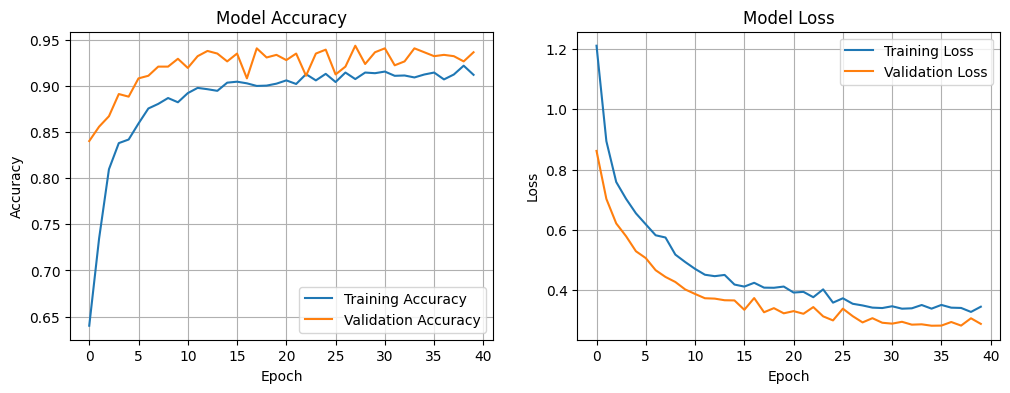

In [15]:
# Plot training and validation
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()

plt.show()

In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9306 - loss: 0.2969
Test Loss: 0.2826, Test Accuracy: 0.9364


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

      Normal       0.93      0.96      0.94       398
Speech Delay       0.95      0.91      0.93       309

    accuracy                           0.94       707
   macro avg       0.94      0.93      0.93       707
weighted avg       0.94      0.94      0.94       707



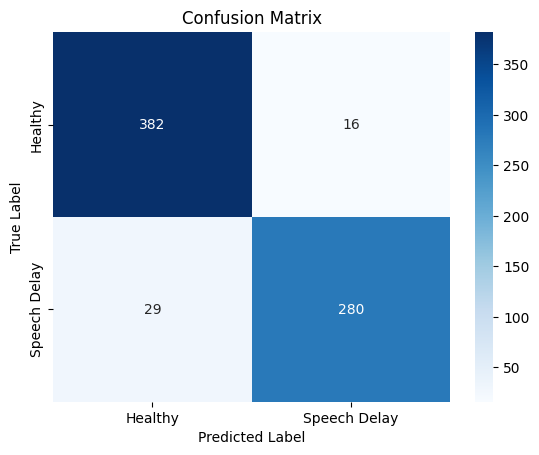

In [17]:
# Display model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Speech Delay"], yticklabels=["Healthy", "Speech Delay"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Upload audio file
uploaded = files.upload()

# Function to classify uploaded audio file
def classify_uploaded_audio():
    # Get the uploaded file path
    audio_path = '/content/' + list(uploaded.keys())[0]

    # Load the audio file and preprocess it
    waveform, sr = librosa.load(audio_path, sr=16000, mono=True)

    # Extract YAMNet features
    features = extract_yamnet_features(waveform)
    features = np.expand_dims(features, axis=0)  # Reshape for model input

    # Predict using the trained model
    prediction = model.predict(features)[0][0]  # Output is a single value

    # Map prediction to class
    if prediction >= 0.5:
        result = "Masih Salah, Coba Lagi"
    else:
        result = "Bagus, Mari Lanjutkan"

    print(f"Prediction: {result} (Score: {prediction:.4f})")
    os.remove(audio_path) # Delete audio after used
    return result, prediction

# Step 3: Run the classification function
classify_uploaded_audio()

Saving 05d18852_nohash_0.wav to 05d18852_nohash_0.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction: Bagus, Mari Lanjutkan (Score: 0.0144)


('Bagus, Mari Lanjutkan', 0.014423301)

In [ ]:
# Save the model
model.save('speech_classification_model.h5')

# Download the model file
files.download('speech_classification_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>